In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/physionet-ecg-image-digitization/sample_submission.parquet
/kaggle/input/physionet-ecg-image-digitization/train.csv
/kaggle/input/physionet-ecg-image-digitization/test.csv
/kaggle/input/physionet-ecg-image-digitization/test/2352854581.png
/kaggle/input/physionet-ecg-image-digitization/test/1053922973.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0005.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0006.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0011.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0004.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893.csv
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0012.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0003.png
/kaggle/input/physionet-ecg-image-digitization/train/735384893/735384893-0001.png
/kaggle/input/physionet-ecg-i

GPU: Tesla T4
ECG IMAGE TO TIME-SERIES - FIXED VERSION

DATA VERIFICATION

train.csv loaded: (977, 3)
Columns: ['id', 'fs', 'sig_len']
Sample rows:
          id    fs  sig_len
0    7663343   500     5000
1   10140238  1000    10000
2   11842146  1000    10000
3   19030958   250     2500
4   19585145   512     5120
5   31175200   250     2500
6   31294838   512     5120
7   32650710   250     2500
8   35187032   500     5000
9   36494663  1025    10250
10  37579740  1000    10000
11  38118497  1000    10000
12  46930936   250     2500
13  49746380   250     2500
14  54505697   500     5000
15  57127905   500     5000
16  57655084  1000    10000
17  63496229  1000    10000
18  66870442   500     5000
19  78833408   512     5120
Unique values in first column: 977

test.csv loaded: (24, 4)
Columns: ['id', 'lead', 'fs', 'number_of_rows']
Sample rows:
            id lead    fs  number_of_rows
0   1053922973    I  1000            2500
1   1053922973   II  1000           10000
2   1053922973  

Validation: 100%|██████████| 83/83 [02:50<00:00,  2.05s/it, loss=0.0080, snr=-0.00]



📊 Epoch Summary:
  Train Loss: 0.0095 | Train SNR: -0.01 dB
  Val Loss: 0.0098 | Val SNR: -0.00 dB
  LR: 0.000050
  ✅ Best model saved (SNR: -0.00 dB)
✅ Saved training_history.png


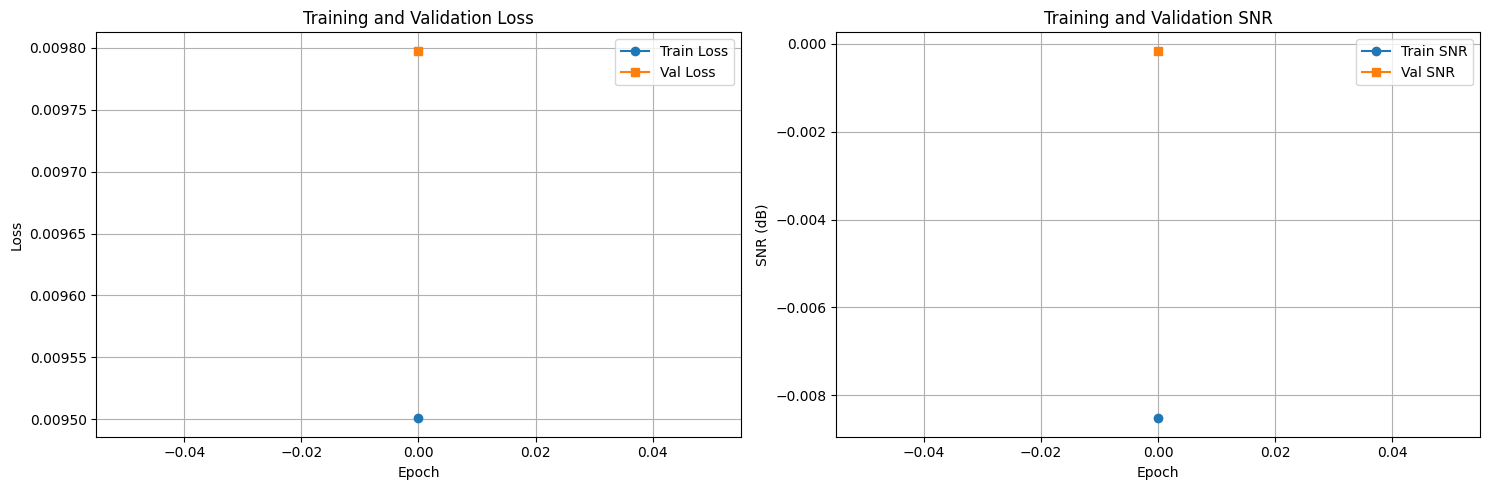


✅ TRAINING COMPLETE
Best Val SNR: -0.00 dB

GENERATING SUBMISSION
Test images: 2
  Loaded 2 samples


Inference: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


✅ Saved: submission.csv (120000 rows)

Sample submission:
                 id     value
0    1053922973_0_I -0.019494
1   1053922973_0_II  0.029808
2  1053922973_0_III  0.014411
3  1053922973_0_aVR  0.011363
4  1053922973_0_aVL -0.032385
5  1053922973_0_aVF -0.002753
6   1053922973_0_V1  0.014420
7   1053922973_0_V2  0.004571
8   1053922973_0_V3 -0.007150
9   1053922973_0_V4  0.017145

✅ PIPELINE COMPLETE


In [2]:
# ECG Image to Time-Series Extraction - FIXED DATA LOADING
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import warnings
import gc
import multiprocessing
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

# Device setup
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    torch.set_num_threads(multiprocessing.cpu_count())
    print(f"CPU: {multiprocessing.cpu_count()} cores")

print("="*80)
print("ECG IMAGE TO TIME-SERIES - FIXED VERSION")
print("="*80)

# ============================================================================
# DATA EXPLORATION WITH PROPER CSV LOADING
# ============================================================================

def explore_data():
    base_path = '/kaggle/input/physionet-ecg-image-digitization'
    
    print("\n" + "="*80)
    print("DATA VERIFICATION")
    print("="*80)
    
    # Load train.csv and test.csv
    train_csv_path = os.path.join(base_path, 'train.csv')
    test_csv_path = os.path.join(base_path, 'test.csv')
    
    train_df = None
    test_df = None
    
    if os.path.exists(train_csv_path):
        train_df = pd.read_csv(train_csv_path)
        print(f"\ntrain.csv loaded: {train_df.shape}")
        print(f"Columns: {list(train_df.columns)}")
        print(f"Sample rows:\n{train_df.head(20)}")
        print(f"Unique values in first column: {train_df.iloc[:, 0].nunique()}")
    else:
        print("⚠️  train.csv not found!")
    
    if os.path.exists(test_csv_path):
        test_df = pd.read_csv(test_csv_path)
        print(f"\ntest.csv loaded: {test_df.shape}")
        print(f"Columns: {list(test_df.columns)}")
        print(f"Sample rows:\n{test_df.head(20)}")
    else:
        print("⚠️  test.csv not found!")
    
    # Check train folder structure
    train_path = os.path.join(base_path, 'train')
    patient_dirs = []
    if os.path.exists(train_path):
        patient_dirs = sorted([d for d in os.listdir(train_path) 
                              if os.path.isdir(os.path.join(train_path, d))])
        print(f"\nTotal patient folders: {len(patient_dirs)}")
        
        # Check first few patient folders
        for i, pid in enumerate(patient_dirs[:3]):
            p_folder = os.path.join(train_path, pid)
            files = sorted(os.listdir(p_folder))
            csv_files = [f for f in files if f.endswith('.csv')]
            png_files = [f for f in files if f.endswith('.png')]
            print(f"\nPatient {pid}:")
            print(f"  CSV files: {csv_files}")
            print(f"  PNG files ({len(png_files)}): {png_files[:3]}...")
            
            # Check CSV structure
            if csv_files:
                csv_path = os.path.join(p_folder, csv_files[0])
                df = pd.read_csv(csv_path)
                print(f"  CSV shape: {df.shape}")
                print(f"  CSV columns: {list(df.columns)[:5]}...")
    
    # Check test folder
    test_path = os.path.join(base_path, 'test')
    if os.path.exists(test_path):
        test_files = sorted([f for f in os.listdir(test_path) if f.endswith('.png')])
        print(f"\nTest images: {len(test_files)}")
        if test_files:
            print(f"  Sample: {test_files[:5]}")
    
    return base_path, train_df, test_df, patient_dirs

base_path, train_df, test_df, patient_dirs = explore_data()

# ============================================================================
# DATASET WITH PROPER CSV MAPPING
# ============================================================================

class ECGDataset(Dataset):
    def __init__(self, base_path, patient_ids, transform=None, is_test=False, max_len=5000):
        """
        Args:
            base_path: Base path to data
            patient_ids: List of patient IDs or DataFrame
            transform: Image transforms
            is_test: Whether this is test set
            max_len: Maximum sequence length
        """
        self.base_path = base_path
        self.transform = transform
        self.is_test = is_test
        self.max_len = max_len
        self.samples = []
        
        if is_test:
            # Test set: just load images
            test_dir = os.path.join(base_path, 'test')
            test_files = sorted([f for f in os.listdir(test_dir) if f.endswith('.png')])
            for f in test_files:
                self.samples.append({
                    'patient_id': f.replace('.png', ''),
                    'image_path': os.path.join(test_dir, f)
                })
        else:
            # Training set: load images and corresponding time-series
            train_dir = os.path.join(base_path, 'train')
            
            # Handle both list of IDs and DataFrame
            if isinstance(patient_ids, pd.DataFrame):
                patient_ids = patient_ids['patient_id'].unique() if 'patient_id' in patient_ids.columns else patient_ids.iloc[:, 0].unique()
            
            for pid in patient_ids:
                p_folder = os.path.join(train_dir, str(pid))
                if not os.path.exists(p_folder):
                    continue
                
                # Get all images for this patient
                images = sorted([f for f in os.listdir(p_folder) if f.endswith('.png')])
                
                # Get CSV file for this patient
                csv_file = os.path.join(p_folder, f"{pid}.csv")
                
                if os.path.exists(csv_file):
                    for img in images:
                        self.samples.append({
                            'patient_id': pid,
                            'image_path': os.path.join(p_folder, img),
                            'csv_path': csv_file
                        })
        
        print(f"  Loaded {len(self.samples)} samples")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        image = cv2.imread(sample['image_path'])
        if image is None:
            print(f"⚠️  Failed to load: {sample['image_path']}")
            image = np.zeros((512, 512, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image, sample['patient_id']
        
        # Load target from CSV
        target = torch.zeros(12, self.max_len)
        
        if 'csv_path' in sample and os.path.exists(sample['csv_path']):
            try:
                df = pd.read_csv(sample['csv_path'])
                df = df.fillna(0.0)
                
                # Extract 12 leads
                for lead_idx in range(min(12, len(df.columns))):
                    lead_data = df.iloc[:, lead_idx].values.astype(np.float32)
                    length = min(len(lead_data), self.max_len)
                    target[lead_idx, :length] = torch.from_numpy(lead_data[:length])
                    
            except Exception as e:
                print(f"Error loading {sample['csv_path']}: {e}")
        
        return image, target, sample['patient_id']


def get_transforms(is_train=True, img_size=(384, 384)):
    if is_train:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(img_size),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# ============================================================================
# MODEL
# ============================================================================

class ECGEncoder(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.fc = nn.Linear(256, latent_dim)
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class ECGDecoder(nn.Module):
    def __init__(self, latent_dim=256, seq_len=5000, num_leads=12):
        super().__init__()
        
        self.seq_len = seq_len
        self.fc_init = nn.Linear(latent_dim, 128)
        self.lstm1 = nn.LSTM(128, 256, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(512, 128, batch_first=True, bidirectional=True)
        self.fc_out = nn.Linear(256, num_leads)
    
    def forward(self, x):
        x = self.fc_init(x)
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.fc_out(x)
        x = x.permute(0, 2, 1)
        return x


class ECGModel(nn.Module):
    def __init__(self, latent_dim=256, seq_len=5000, num_leads=12):
        super().__init__()
        self.encoder = ECGEncoder(latent_dim)
        self.decoder = ECGDecoder(latent_dim, seq_len, num_leads)
    
    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

# ============================================================================
# SNR CALCULATION
# ============================================================================

def calculate_snr_fixed(pred, target, eps=1e-10):
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    
    snr_values = []
    
    for i in range(pred.shape[0]):
        p = pred[i] - np.mean(pred[i], axis=1, keepdims=True)
        t = target[i] - np.mean(target[i], axis=1, keepdims=True)
        
        signal_power = np.sum(t ** 2) + eps
        noise_power = np.sum((p - t) ** 2) + eps
        snr_db = 10 * np.log10(signal_power / noise_power)
        
        if not np.isnan(snr_db) and not np.isinf(snr_db):
            snr_values.append(snr_db)
    
    return np.mean(snr_values) if snr_values else float('nan')

# ============================================================================
# TRAINING WITH VISUALIZATION
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    total_loss = 0
    total_snr = 0
    num_batches = 0
    
    pbar = tqdm(loader, desc='Training')
    
    for batch_idx, batch in enumerate(pbar):
        try:
            images, targets, _ = batch
            images = images.to(device)
            targets = targets.to(device)
            
            if torch.isnan(images).any() or torch.isnan(targets).any():
                continue
            
            optimizer.zero_grad()
            
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    min_len = min(outputs.shape[2], targets.shape[2])
                    outputs = outputs[:, :, :min_len]
                    targets = targets[:, :, :min_len]
                    loss = criterion(outputs, targets)
                
                if torch.isnan(loss):
                    continue
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                min_len = min(outputs.shape[2], targets.shape[2])
                outputs = outputs[:, :, :min_len]
                targets = targets[:, :, :min_len]
                loss = criterion(outputs, targets)
                
                if torch.isnan(loss):
                    continue
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            snr = calculate_snr_fixed(outputs, targets)
            
            if not np.isnan(snr):
                total_loss += loss.item()
                total_snr += snr
                num_batches += 1
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'snr': f'{snr:.2f}' if not np.isnan(snr) else 'NaN'
            })
            
        except Exception as e:
            print(f"❌ Error in batch {batch_idx}: {e}")
            continue
    
    if num_batches == 0:
        return float('nan'), float('nan')
    
    return total_loss / num_batches, total_snr / num_batches


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_snr = 0
    num_batches = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        
        for batch in pbar:
            try:
                images, targets, _ = batch
                images = images.to(device)
                targets = targets.to(device)
                
                outputs = model(images)
                min_len = min(outputs.shape[2], targets.shape[2])
                outputs = outputs[:, :, :min_len]
                targets = targets[:, :, :min_len]
                
                loss = criterion(outputs, targets)
                
                if torch.isnan(loss):
                    continue
                
                snr = calculate_snr_fixed(outputs, targets)
                
                if not np.isnan(snr):
                    total_loss += loss.item()
                    total_snr += snr
                    num_batches += 1
                
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'snr': f'{snr:.2f}' if not np.isnan(snr) else 'NaN'
                })
                
            except Exception as e:
                continue
    
    if num_batches == 0:
        return float('nan'), float('nan')
    
    return total_loss / num_batches, total_snr / num_batches


def plot_training_history(history):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # SNR plot
    axes[1].plot(history['train_snr'], label='Train SNR', marker='o')
    axes[1].plot(history['val_snr'], label='Val SNR', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('SNR (dB)')
    axes[1].set_title('Training and Validation SNR')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    print("✅ Saved training_history.png")
    plt.show()

# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    print("\n" + "="*80)
    print("TRAINING PIPELINE")
    print("="*80)
    
    config = {
        'img_size': (384, 384),
        'batch_size': 16,
        'num_epochs': 1,
        'learning_rate': 1e-4,
        'latent_dim': 256,
        'seq_length': 5000,
        'num_leads': 12,
        'num_workers': 4,
        'warmup_epochs': 2
    }
    
    print("\nConfiguration:")
    for k, v in config.items():
        print(f"  {k}: {v}")
    
    # Use patient directories directly
    from sklearn.model_selection import train_test_split
    
    print(f"\nTotal patients available: {len(patient_dirs)}")
    train_ids, val_ids = train_test_split(patient_dirs, test_size=0.15, random_state=42)
    
    print(f"Train patients: {len(train_ids)}")
    print(f"Val patients: {len(val_ids)}")
    
    # Create datasets
    print("\nCreating datasets...")
    train_dataset = ECGDataset(base_path, train_ids, 
                               transform=get_transforms(True, config['img_size']),
                               max_len=config['seq_length'])
    
    val_dataset = ECGDataset(base_path, val_ids,
                            transform=get_transforms(False, config['img_size']),
                            max_len=config['seq_length'])
    
    train_loader = DataLoader(train_dataset, 
                             batch_size=config['batch_size'],
                             shuffle=True,
                             num_workers=config['num_workers'],
                             pin_memory=torch.cuda.is_available())
    
    val_loader = DataLoader(val_dataset,
                           batch_size=config['batch_size'],
                           shuffle=False,
                           num_workers=config['num_workers'],
                           pin_memory=torch.cuda.is_available())
    
    # Model
    print("\nInitializing model...")
    model = ECGModel(config['latent_dim'], config['seq_length'], config['num_leads']).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {total_params:,}")
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)
    
    from torch.optim.lr_scheduler import CosineAnnealingLR
    scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'] - config['warmup_epochs'])
    
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    # Training
    history = {'train_loss': [], 'val_loss': [], 'train_snr': [], 'val_snr': []}
    best_val_snr = -1000
    
    print("\n" + "="*80)
    print("STARTING TRAINING")
    print("="*80)
    
    for epoch in range(config['num_epochs']):
        print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
        print("-" * 80)
        
        if epoch < config['warmup_epochs']:
            lr = config['learning_rate'] * (epoch + 1) / config['warmup_epochs']
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print(f"Warmup LR: {lr:.6f}")
        
        train_loss, train_snr = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_snr = validate(model, val_loader, criterion, device)
        
        if epoch >= config['warmup_epochs']:
            scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_snr'].append(train_snr)
        history['val_snr'].append(val_snr)
        
        print(f"\n📊 Epoch Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train SNR: {train_snr:.2f} dB")
        print(f"  Val Loss: {val_loss:.4f} | Val SNR: {val_snr:.2f} dB")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if not np.isnan(val_snr) and val_snr > best_val_snr:
            best_val_snr = val_snr
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  ✅ Best model saved (SNR: {best_val_snr:.2f} dB)")
        
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("\n⚠️  Training collapsed. Stopping.")
            break
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
    
    # Plot training curves
    plot_training_history(history)
    
    print(f"\n{'='*80}")
    print(f"✅ TRAINING COMPLETE")
    print(f"Best Val SNR: {best_val_snr:.2f} dB")
    print(f"{'='*80}")
    
    return model, history


def generate_submission(model, base_path, device):
    """Generate submission in correct format"""
    print("\n" + "="*80)
    print("GENERATING SUBMISSION")
    print("="*80)
    
    # Get test files directly from directory
    test_dir = os.path.join(base_path, 'test')
    test_files = sorted([f for f in os.listdir(test_dir) if f.endswith('.png')])
    test_ids = [f.replace('.png', '') for f in test_files]
    
    print(f"Test images: {len(test_ids)}")
    
    test_dataset = ECGDataset(base_path, test_ids,
                             transform=get_transforms(False, (384, 384)),
                             is_test=True, max_len=5000)
    
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                            num_workers=4, pin_memory=torch.cuda.is_available())
    
    model.eval()
    submissions = []
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    
    with torch.no_grad():
        for images, patient_ids in tqdm(test_loader, desc='Inference'):
            images = images.to(device)
            outputs = model(images).cpu().numpy()
            
            for b_idx, pid in enumerate(patient_ids):
                for t_idx in range(outputs.shape[2]):
                    for l_idx, lead in enumerate(lead_names):
                        submissions.append({
                            'id': f"{pid}_{t_idx}_{lead}",
                            'value': float(outputs[b_idx, l_idx, t_idx])
                        })
    
    df = pd.DataFrame(submissions)
    df.to_csv('submission.csv', index=False)
    print(f"✅ Saved: submission.csv ({len(df)} rows)")
    print(f"\nSample submission:")
    print(df.head(10))
    return df


# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    if len(patient_dirs) > 0:
        model, history = main()
        submission = generate_submission(model, base_path, device)
    else:
        print("❌ No patient directories found!")
    
    print("\n" + "="*80)
    print("✅ PIPELINE COMPLETE")
    print("="*80)